# Reinforcement learning for tic-tac-toe

In [51]:
import random
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
from IPython.display import clear_output
from IPython import display
from statistics import mean
import copy
import hashlib
import pickle
!pip install torch-lr-finder
from torch_lr_finder import LRFinder as pyLRFinder
# Need to set this field before Run.
isRunningOnColab = False
if isRunningOnColab:
    from google.colab import drive
    !pip install fastai --upgrade
    !pip install -Uqq fastbook
import csv

In [52]:
torch.cuda.is_available()

True

In [53]:
if isRunningOnColab:
        drive.mount('/content/gdrive')

In [54]:
# Used to handle Google drive on Colab, vs accessing on local machine
def getFilePath(fileName):
  if isRunningOnColab:
    filePath = "/content/gdrive/My Drive/"+fileName
  else:
    filePath = fileName
  return filePath

In [55]:
# Most Game specific methods adapted from: https://medium.com/swlh/tic-tac-toe-and-deep-neural-networks-ea600bc53f51
class Game:
    numberOfBoardPositions = 9

    def __init__(self):
        self.board = self.initBoard()

    # Get an empty board
    #
    # 0 indicates an empty space, 1 indicates an 'X' (player 1), and 2 indicates an 'O' (player 2)
    #
    # Initially the board is empty, so we return a 3x3 array of zeroes.
    def initBoard(self):
        board = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
        return board

    # Print the current state of the board
    def printBoard(self):
        for i in range(len(self.board)):
            for j in range(len(self.board[i])):
                mark = " "
                if self.board[i][j] == 1:
                    mark = "X"
                elif self.board[i][j] == 2:
                    mark = "O"
                if j == len(self.board[i]) - 1:
                    print(mark)
                else:
                    print(str(mark) + "|", end="")
            if i < len(self.board) - 1:
                print("-----")

    def isDone(self):
        return True if (self.getWinner() != -1) else False

    # Get a list of valid moves (indices into the board)
    def getMoves(self):
        moves = []
        for i in range(len(self.board)):
            for j in range(len(self.board[i])):
                if self.board[i][j] == 0:
                    moves.append((i, j))
        return moves

    # Declare a winner
    #
    # -1 = game not over
    #  0 = draw
    #  1 = 'X' wins (player 1)
    #  2 = 'O' wins (player 2)
    def getWinner(self):
        candidate = 0
        won = 0

        # Check rows
        for i in range(len(self.board)):
            candidate = 0
            for j in range(len(self.board[i])):

                # Make sure there are no gaps
                if self.board[i][j] == 0:
                    break

                # Identify the front-runner
                if candidate == 0:
                    candidate = self.board[i][j]

                # Determine whether the front-runner has all the slots
                if candidate != self.board[i][j]:
                    break
                elif j == len(self.board[i]) - 1:
                    won = candidate

        if won > 0:
            return won

        # Check columns
        for j in range(len(self.board[0])):
            candidate = 0
            for i in range(len(self.board)):

                # Make sure there are no gaps
                if self.board[i][j] == 0:
                    break

                # Identify the front-runner
                if candidate == 0:
                    candidate = self.board[i][j]

                # Determine whether the front-runner has all the slots
                if candidate != self.board[i][j]:
                    break
                elif i == len(self.board) - 1:
                    won = candidate

        if won > 0:
            return won

        # Check diagonals
        candidate = 0
        for i in range(len(self.board)):
            if self.board[i][i] == 0:
                break
            if candidate == 0:
                candidate = self.board[i][i]
            if candidate != self.board[i][i]:
                break
            elif i == len(self.board) - 1:
                won = candidate

        if won > 0:
            return won

        candidate = 0
        for i in range(len(self.board)):
            if self.board[2 - i][2 - i] == 0:
                break
            if candidate == 0:
                candidate = self.board[2 - i][2 - i]
            if candidate != self.board[2 - i][2 - i]:
                break
            elif i == len(self.board) - 1:
                won = candidate

        if won > 0:
            return won

        # Still no winner?
        if len(self.getMoves()) == 0:
            # It's a draw
            return 0
        else:
            # Still more moves to make
            return -1

    def validateMove(self, addpos=(0, 0)):
        row = addpos[0]
        col = addpos[1]

        if row < 0 or row > 2:
            return False
        if col < 0 or col > 2:
            return False

        return self.board[row][col] == 0

    def makeMove(self, addpos, player):
        if self.validateMove(addpos):
            row = addpos[0]
            col = addpos[1]
            self.board[row][col] = player
            return True
        return False

    def convertMoveTupleToActionIndex(self, move):
        row = move[0]
        col = move[1]
        actionIndex = row * 3 + col
        return actionIndex

    def convertActionIndexToTuple(self, index):
        row = index // 3
        col = index % 3
        return (row, col)

    def convertBoardToState(self):
        return self.convertInputBoardToState(self.board)

    def convertInputBoardToState(self, board):
        return np.array(board).reshape(1, Game.numberOfBoardPositions).astype(int)

    def getFinalReward(self, player):
        winner = self.getWinner()
        if winner == 0:
            return 5
        elif winner == player:
            return 10
        else:
            return -10

In [56]:
# Used for keeping track of states, rewards, actions during training, per move.
class TransitionState:
    def __init__(self, state1, state2, action, winner, done, isValid, epoch, reward=0):
        self.state1 = state1
        self.state2 = state2
        self.action = action
        self.winner = winner
        self.done = done
        self.isValid = isValid
        self.reward = reward
        self.epoch = epoch

    def __str__(self):
        return " ".join(
            [
                "TransitionState:",
                "winner =",
                str(self.winner),
                "done =",
                str(self.done),
                "isValid=",
                str(self.isValid),
                "action=",
                str(self.action),
                "reward:",
                str(self.reward),
                "state1:",
                str(self.state1),
                "state2:",
                str(self.state2),
                "epoch:",
                str(self.epoch),
            ]
        )

In [57]:
from collections import deque
from IPython.display import clear_output

#A common base class class for training
class Trainer:
    def __init__(self):
        self.epochs = 100
        self.losses = []
        self.finalRewards = []
        self.finalRewardsMean = []
        self.gamma = 0.8
        self.epsilon = 1.0
        self.ml_player = 1
        self.opponent = 2
        self.printCommands = []

    def transitionPlayerStateForTraining(self, game, epsilon, ml_player, i):
        pass

    def trainBatch(self, batch, finalReward, epoch):
        self.assignRewardToBatch(batch, finalReward)

    def assignRewardToBatch(self, batch, finalReward):
        for j in range(len(batch) - 1, -1, -1):
            item = batch[j]
            if item.isValid == False:
                item.reward = -10
            elif item.done:
                item.reward = finalReward
            else:
                item.reward = -1

    def train(self):
        for i in range(self.epochs):
            printCommands = []
            printCommands.append("Running epoch:" + str(i + 1))
            game = Game()
            status = 1

            self.epochTransitionStates = []
            epochMoves = []

            if i % 2 == 0:
                ml_player_starts = True
            else:
                ml_player_starts = False
            opponent_made_first_move = False
            while status == 1:
                transitionState = None
                done = None
                winner = None

                if (
                    ml_player_starts == True or opponent_made_first_move == True
                ):  # Plays "X"
                    transitionState = self.transitionPlayerStateForTraining(
                        game, self.epsilon, self.ml_player, i
                    )
                    epochMoves.append(
                        (
                            game.convertActionIndexToTuple(transitionState.action),
                            transitionState.isValid,
                            self.ml_player,
                        )
                    )
                    # Now opponent turn
                    if (
                        transitionState.done == False
                        and transitionState.isValid == True
                    ):
                        validMoves = game.getMoves()
                        randomMove = validMoves[random.randint(0, len(validMoves) - 1)]
                        isValidMove = game.makeMove(randomMove, self.opponent)
                        state2_ = game.convertBoardToState()
                        transitionState.state2 = state2_
                        epochMoves.append((randomMove, isValidMove, self.opponent))
                        winner = game.getWinner()
                        transitionState.winner = winner

                        done = game.isDone()
                        if done == True:
                            transitionState.done = True

                # ML player plays "X", but takes second turn at start [not according to rules, but for learning]
                else:
                    validMoves = game.getMoves()
                    randomMove = validMoves[random.randint(0, len(validMoves) - 1)]
                    isValidMove = game.makeMove(randomMove, self.opponent)
                    epochMoves.append((randomMove, isValidMove, self.opponent))
                    opponent_made_first_move = True

                if transitionState is not None:
                    self.epochTransitionStates.append(transitionState)

                    if transitionState.done == True:
                        miniBatch = self.epochTransitionStates

                        printCommands.append("Winner is:" + str(transitionState.winner))
                        finalReward = game.getFinalReward(self.ml_player)
                        printCommands.append("Reward is:" + str(finalReward))
                        self.finalRewards.append(finalReward)
                        meanFinalReward = mean(self.finalRewards)
                        self.finalRewardsMean.append(meanFinalReward)
                        formattedFinalMeanRewards = "{:.2f}".format(meanFinalReward)
                        printCommands.append(
                            "Average Reward: " + formattedFinalMeanRewards
                        )

                        self.trainBatch(miniBatch, finalReward, i)

                        status = 0

            if len(self.losses) > 0:
                formattedMeanLosses = "{:.2f}".format(
                    mean(list(map(lambda n: n[1], self.losses)))
                )
                printCommands.append("Average Loss: " + formattedMeanLosses)

            if self.epsilon > 0.5:  # R
                self.epsilon -= 1 / self.epochs

            print(*printCommands, end="\n", sep=", ")

In [58]:
# A base class that represent a generic model
class Model:
  loadModelFilename = None

  def __init__(self):
    self.rawModel = None

  def loadPreviousModel(loadModelFilename):
    try:
      with open(loadModelFilename,"rb") as f:
        return pickle.load(f)
    except Exception as e:
      print("Error occurred in loading file.")

  def get():
      pass

  def defaultRawModel():
    pass

  #State is a 1-D numpy array of the board state
  def __call__(self, state):
      pass

In [59]:
# The Q Table concrete model
class QTableModel(Model):
  loadModelFilename = "qtable_data.pkl"

  def __init__(self, rawModel):
    super().__init__()
    self.rawModel = rawModel

  def get(self):
      return self.rawModel

  def defaultRawModel():
    return {}

  def __call__(self, state):
      stateHash = self.getStateHash(state)
      self.initKeyIfNeeded(stateHash, state)
      return self.rawModel[stateHash][0]

  def initKeyIfNeeded(self, key, state):
      #Initialize key if needed
      if not key in self.rawModel:
        #We also store the state, since hashing is irreversible.
        self.rawModel[key] = ([0] * Game.numberOfBoardPositions, state)

  def getStateHash(self, state):
      return hashlib.sha1(state).hexdigest()

  def update(self, state, action, value):
      stateHash = self.getStateHash(state)
      self.initKeyIfNeeded(stateHash, state)
      self.rawModel[stateHash][0][action] = value

In [60]:
# The neural net concrete model
class NNModel(Model):

  loadModelFilename =  "nnModel_Tic_Tac_Toe_data.pkl"

  def __init__(self, rawModel):
      self.rawModel = rawModel

  def get(self):
      return self.rawModel

  def defaultRawModel():
    l1 = Game.numberOfBoardPositions
    l2 = 150
    l3 = 100
    l4 = Game.numberOfBoardPositions

    model = torch.nn.Sequential(
      torch.nn.Linear(l1, 200),
      torch.nn.ReLU(),
      torch.nn.Linear(200, 125),
      torch.nn.Dropout(p=0.2),
      torch.nn.ReLU(),
      torch.nn.Linear(125, 75),
      torch.nn.Dropout(p=0.1),
      torch.nn.ReLU(),
      torch.nn.Linear(75, 25),
      torch.nn.ReLU(),
      torch.nn.Linear(25, l4),
    )
    return model

  def __call__(self, state):
      tensorState = torch.from_numpy(state).float()
      return self.rawModel(tensorState).squeeze().data.numpy()

In [61]:
# The concrete Learner for the Q Table approach
class QTableLearner(Trainer):
    def __init__(self, model):
        super().__init__()
        self.epochs = 20000
        self.model = model
        self.learning_rate = 0.1
        self.gamma = 0.9

    def trainBatch(self, batch, finalReward, epoch):
        super().trainBatch(batch, finalReward, epoch)
        self.doQTableUpdateForBatch(batch)

    def doQTableUpdateForBatch(self, batch):
        for j in range(len(batch) - 1, -1, -1):
            item = batch[j]
            current_state = item.state1
            old_value = self.model(current_state)[item.action]

            if item.isValid == True and item.done != True:
                next_state = item.state2
                state2Val = self.model(next_state)
                next_max = max(state2Val)
            else:
                next_max = 0
            new_value = (1 - self.learning_rate) * old_value + self.learning_rate * (
                item.reward + self.gamma * next_max
            )
            self.model.update(current_state, item.action, new_value)

    def transitionPlayerStateForTraining(self, game, epsilon, ml_player, epoch):
        state1_ = game.convertBoardToState()
        if random.random() < epsilon:
            action_ = np.random.randint(0, Game.numberOfBoardPositions)
        else:
            pred = self.model(state1_)
            max_value = max(pred)
            action_ = pred.index(max_value)
        action = game.convertActionIndexToTuple(action_)
        isValid = game.makeMove(action, ml_player)
        winner = game.getWinner()
        done = game.isDone()
        # Provisional state2. If the opponent makes a move, then state2 will be the state after the opponent's move.
        state2_ = game.convertBoardToState()
        return TransitionState(state1_, state2_, action_, winner, done, isValid, epoch)

In [62]:
# The concrete learner for the neural net
class NNLearner(Trainer):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.mem_size = 500
        self.min_batch_size = 300
        self.epochs = 100
        self.replay = deque(maxlen=self.mem_size)
        self.loss_fn = torch.nn.MSELoss()
        self.learning_rate = 1e-3
        self.optimizer = torch.optim.Adam(
            self.model.get().parameters(), lr=self.learning_rate
        )

    def trainBatch(self, batch, finalReward, epoch):
        super().trainBatch(batch, finalReward, epoch)
        self.replay.extend(self.epochTransitionStates)
        if len(self.replay) >= self.min_batch_size:
            loss = self.trainBatchNN(self.replay)
            self.losses.append((epoch, loss.item()))

    def trainBatchNN(self, batch):
        state1_batch = torch.cat([torch.tensor(item.state1) for item in batch]).float()
        action_batch = torch.Tensor([item.action for item in batch])
        reward_batch = torch.Tensor([item.reward for item in batch])
        state2_batch = torch.cat([torch.tensor(item.state2) for item in batch]).float()
        needs_next_max_batch = torch.Tensor(
            [(item.isValid == True and item.done != True) for item in batch]
        )
        self.optimizer.zero_grad()
        rawNNModel = self.model.get()
        Q1 = rawNNModel(state1_batch)

        with torch.no_grad():
            Q2 = rawNNModel(state2_batch)

        X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
        Y = reward_batch + self.gamma * (
            needs_next_max_batch * torch.max(Q2, dim=1).values
        )

        loss = self.loss_fn(X, Y.detach())
        loss.requres_grad = True
        loss.backward()
        self.optimizer.step()
        return loss

    # Makes a move based on the model or random, and track the state changes.
    def transitionPlayerStateForTraining(self, game, epsilon, ml_player, epoch):
        state1_ = game.convertBoardToState()
        state1 = state1_ + np.random.rand(1, Game.numberOfBoardPositions) / 10.0
        qval = self.model(state1)

        if random.random() < epsilon:
            action_ = np.random.randint(0, Game.numberOfBoardPositions)
        else:
            action_ = np.argmax(qval)

        action = game.convertActionIndexToTuple(action_)
        isValid = game.makeMove(action, ml_player)
        winner = game.getWinner()
        done = game.isDone()

        # Provisional state2. If the opponent makes a move, then state2 will be the state after the opponent's move.
        state2_ = game.convertBoardToState()
        state2 = state2_ + np.random.rand(1, Game.numberOfBoardPositions) / 10.0

        return TransitionState(state1, state2, action_, winner, done, isValid, epoch)

In [63]:
# Now train the Neural net

nnModel = NNModel(NNModel.defaultRawModel())
#nnModel = NNModel(Model.loadPreviousModel(NNModel.loadModelFilename))
nnLearner = NNLearner(nnModel)
nnLearner.train()

Running epoch:1, Winner is:0, Reward is:5, Average Reward: 5.00
Running epoch:2, Winner is:0, Reward is:5, Average Reward: 5.00
Running epoch:3, Winner is:1, Reward is:10, Average Reward: 6.67
Running epoch:4, Winner is:2, Reward is:-10, Average Reward: 2.50
Running epoch:5, Winner is:0, Reward is:5, Average Reward: 3.00
Running epoch:6, Winner is:2, Reward is:-10, Average Reward: 0.83
Running epoch:7, Winner is:1, Reward is:10, Average Reward: 2.14
Running epoch:8, Winner is:0, Reward is:5, Average Reward: 2.50
Running epoch:9, Winner is:0, Reward is:5, Average Reward: 2.78
Running epoch:10, Winner is:0, Reward is:5, Average Reward: 3.00
Running epoch:11, Winner is:2, Reward is:-10, Average Reward: 1.82
Running epoch:12, Winner is:2, Reward is:-10, Average Reward: 0.83
Running epoch:13, Winner is:1, Reward is:10, Average Reward: 1.54
Running epoch:14, Winner is:0, Reward is:5, Average Reward: 1.79
Running epoch:15, Winner is:0, Reward is:5, Average Reward: 2.00
Running epoch:16, Winne

Text(0, 0.5, 'Mean End Rewards')

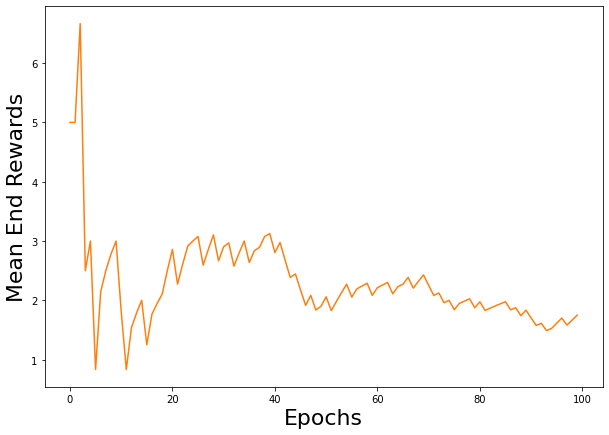

In [64]:
# Plot the rewards vs epochs for the neural net training.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot([])
plt.plot(nnLearner.finalRewardsMean)
plt.xlabel("Epochs", fontsize=22)
plt.ylabel("Mean End Rewards", fontsize=22)

In [65]:
# Now train the QTable
qTableModel = QTableModel(QTableModel.defaultRawModel())
#qTableModel = QTableModel(Model.loadPreviousModel(QTableModel.loadModelFilename))
qTableLearner = QTableLearner(qTableModel)
qTableLearner.train()

Running epoch:1, Winner is:2, Reward is:-10, Average Reward: -10.00
Running epoch:2, Winner is:1, Reward is:10, Average Reward: 0.00
Running epoch:3, Winner is:1, Reward is:10, Average Reward: 3.33
Running epoch:4, Winner is:2, Reward is:-10, Average Reward: 0.00
Running epoch:5, Winner is:0, Reward is:5, Average Reward: 1.00
Running epoch:6, Winner is:2, Reward is:-10, Average Reward: -0.83
Running epoch:7, Winner is:1, Reward is:10, Average Reward: 0.71
Running epoch:8, Winner is:2, Reward is:-10, Average Reward: -0.62
Running epoch:9, Winner is:1, Reward is:10, Average Reward: 0.56
Running epoch:10, Winner is:1, Reward is:10, Average Reward: 1.50
Running epoch:11, Winner is:2, Reward is:-10, Average Reward: 0.45
Running epoch:12, Winner is:1, Reward is:10, Average Reward: 1.25
Running epoch:13, Winner is:1, Reward is:10, Average Reward: 1.92
Running epoch:14, Winner is:0, Reward is:5, Average Reward: 2.14
Running epoch:15, Winner is:2, Reward is:-10, Average Reward: 1.33
Running epo

Text(0, 0.5, 'Mean End Rewards')

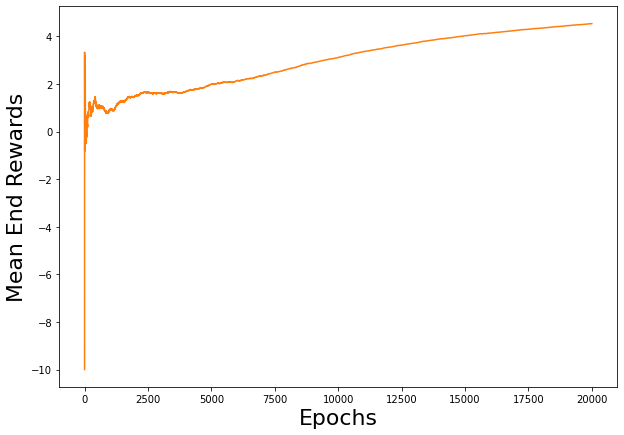

In [66]:
# Plot the rewards vs epochs for the Q Table training results
plt.figure(figsize=(10, 7))
# Fix bug where it only works if an initial plot is done with blank data
plt.plot([])
plt.plot(qTableLearner.finalRewardsMean)
plt.xlabel("Epochs", fontsize=22)
plt.ylabel("Mean End Rewards", fontsize=22)

In [67]:
# Used for running simulations on models, or playing human/model games
class PlayMaker:
    def __init__(self):
        random.seed()

    # Simulate a game
    def simulateGame(self, p1Model=None, p2Model=None, rnd=0):
        game = Game()
        playerToMove = 1

        while game.getWinner() == -1:

            # Chose a move (random or use a player model if provided)
            move = None
            if playerToMove == 1 and p1Model != None:
                move = self.bestMove(game, playerToMove, p1Model, rnd)
            elif playerToMove == 2 and p2Model != None:
                move = self.bestMove(game, playerToMove, p2Model, rnd)
            else:
                moves = game.getMoves()
                move = moves[random.randint(0, len(moves) - 1)]

            # Make the move
            game.board[move[0]][move[1]] = playerToMove

            # Switch the active player
            playerToMove = 1 if playerToMove == 2 else 2
        return game

    def bestMove(self, game, player, model, rnd=0):
        if player == 1:
            state = game.convertBoardToState()
            actionPred = model(state)
            return self.getFirstValidMoveInPrediction(game, actionPred)
        if player == 2:
            board = game.board
            swappedBoard = self.getSwapPlayersInBoard(board)
            swappedState = game.convertInputBoardToState(swappedBoard)
            actionPred = model(swappedState)
            return self.getFirstValidMoveInPrediction(game, actionPred)

    # The model predictions may not be valid moves. This method determines the highest value prediction that is valid
    # Preds here is an array of move "values" for each action index
    def getFirstValidMoveInPrediction(self, game, preds):
        validMoves = game.getMoves()
        validMoveIndexes = list(map(game.convertMoveTupleToActionIndex, validMoves))

        if preds is not None and (v is not None for v in preds):
            predNp = np.array(preds)
            highToLowSortedPredictionIndexes_np = np.argsort(-1 * predNp)
            # print(highToLowSortedPredictionIndexes_np)

            highToLowSortedPredictionIndexes = (
                highToLowSortedPredictionIndexes_np.squeeze().tolist()
            )
            highestValidPredIndex = next(
                (
                    x
                    for x in highToLowSortedPredictionIndexes
                    if (x in validMoveIndexes)
                ),
                None,
            )
            return game.convertActionIndexToTuple(highestValidPredIndex)
        else:
            return validMoves[random.randint(0, len(validMoves) - 1)]

    # Used to swap player states, so that any player can be be used as input to the trained model (trained for player X, not O)
    def getSwapPlayersInBoard(self, board):
        boardSwap = []
        for row in board:
            boardSwap.append([self.togglePlayer(player) for player in row])
        return boardSwap

    def togglePlayer(self, player):
        if player == 1:
            return 2
        elif player == 2:
            return 1
        else:
            return 0

    # Aggregate win/loss/draw stats for a player
    def gameStats(self, games, player=1):
        stats = {"win": 0, "loss": 0, "draw": 0}
        for game in games:
            result = game.getWinner()
            if result == -1:
                continue
            elif result == player:
                stats["win"] += 1
            elif result == 0:
                stats["draw"] += 1
            else:
                stats["loss"] += 1

        winPct = stats["win"] / len(games) * 100
        lossPct = stats["loss"] / len(games) * 100
        drawPct = stats["draw"] / len(games) * 100

        print("Results for player %d:" % (player))
        print("Wins: %d (%.1f%%)" % (stats["win"], winPct))
        print("Loss: %d (%.1f%%)" % (stats["loss"], lossPct))
        print("Draw: %d (%.1f%%)" % (stats["draw"], drawPct))

    # Way to play a human-computer game. First method below starts a game.
    def playNewHumanPlayerGame(self, model, firstMoveByX=None):
        newGame = Game()
        if firstMoveByX is not None:
            newGame.makeMove(firstMoveByX, 1)

            move = playMaker.bestMove(newGame, 2, model)
            print(move)
            newGame.makeMove(move, 2)
        else:
            move = playMaker.bestMove(newGame, 1, model)
            newGame.makeMove(move, 1)
        newGame.printBoard()
        return newGame

    # This method makes the next move in a human-player game
    def playHumanMoveThenMakeModelMove(self, game, move, player, model):
        validMoves = game.getMoves()
        if move in validMoves:
            game.makeMove(move, player)
            winner = game.getWinner()
            if winner == -1:
                opponent = playMaker.togglePlayer(player)
                move = self.bestMove(game, opponent, model)
                game.makeMove(move, opponent)
                winner = game.getWinner()
                if winner != -1:
                    print("Game Over.")
                game.printBoard()
            else:
                print("Game Over.")
                game.printBoard()
        else:
            print("Invalid Move")
            game.printBoard()

    # End of human-player game methods

In [68]:
# Play a single game, with random player and random opponent
playMaker = PlayMaker()
# Simulate a game
history = playMaker.simulateGame()
print(history)

In [69]:
# Play multiple games, with random player and random opponent
games = [playMaker.simulateGame() for _ in range(1000)]
playMaker.gameStats(games)

Results for player 1:
Wins: 512 (51.2%)
Loss: 244 (24.4%)
Draw: 244 (24.4%)


In [70]:
# Player X is QTable, opponent is random
games = [playMaker.simulateGame(p1Model=qTableModel) for _ in range(1000)]
playMaker.gameStats(games)

Results for player 1:
Wins: 970 (97.0%)
Loss: 0 (0.0%)
Draw: 30 (3.0%)


In [71]:
# Player O is QTable, opponent is random
games = [playMaker.simulateGame(p2Model=qTableModel) for _ in range(1000)]
playMaker.gameStats(games)

Results for player 1:
Wins: 52 (5.2%)
Loss: 727 (72.7%)
Draw: 221 (22.1%)


In [72]:
# Player X is Neural net, opponent is random
games = [playMaker.simulateGame(p1Model=nnModel) for _ in range(1000)]
playMaker.gameStats(games)

Results for player 1:
Wins: 379 (37.9%)
Loss: 313 (31.3%)
Draw: 308 (30.8%)


In [73]:
# Player O is Neural net, opponent is random
games = [playMaker.simulateGame(p2Model=nnModel) for _ in range(1000)]
playMaker.gameStats(games)


Results for player 1:
Wins: 637 (63.7%)
Loss: 94 (9.4%)
Draw: 269 (26.9%)


In [74]:
# Player X is Neural net, opponent is QTable
games = [
    playMaker.simulateGame(p1Model=nnModel, p2Model=qTableModel) for _ in range(1000)
]
playMaker.gameStats(games)


Results for player 1:
Wins: 4 (0.4%)
Loss: 301 (30.1%)
Draw: 695 (69.5%)


In [75]:
# Now for manual human computer games

# Play a new game.
# Player X is QTable, makes first move as (0,0), then QTable opponent moves.
game = playMaker.playNewHumanPlayerGame(qTableModel, (0, 0))


(1, 1)
X| | 
-----
 |O| 
-----
 | | 


In [76]:
# Player X now makes move of (1,0), then QTable opponent moves.
playMaker.playHumanMoveThenMakeModelMove(game, (1, 0), 1, qTableModel)

X| | 
-----
X|O| 
-----
O| | 


In [77]:
#Store the model results in a file for Qtable and neural net

filePath = getFilePath("qtable_data.pkl")
with open(filePath,"wb") as f:
  pickle.dump(qTableModel.get(), f)

filePath = getFilePath("nnModel_Tic_Tac_Toe_data.pkl")
with open(filePath, "wb") as f:
    pickle.dump(nnModel.get(), f)

In [78]:
# Method 3: Since the result of the neural net are quite poor, now try to train a Neural net, based on the QTable results.

# First create a CSV file from the model
def createCSVFromQTable(qTableModel):
    filePath = getFilePath("qtable_data.csv")
    with open(filePath,"w") as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',')
        filewriter.writerow(['p0','p1','p2','p3', 'p4','p5','p6','p7', 'p8', 'q0','q1','q2','q3', 'q4','q5','q6','q7', 'q8'])
        model = qTableModel.get()
        for key in model:
          item = model[key]
          qVal = np.round(item[0], decimals=1)
          state = np.squeeze(item[1])
          csvRow = []
          csvRow.extend(list(state))
          csvRow.extend(qVal)
         # print(csvRow)
          filewriter.writerow(csvRow)

createCSVFromQTable(qTableModel)

In [79]:
filePath = getFilePath("qtable_data.csv")
df = pd.read_csv(filePath)
df

,p0,p1,p2,p3,p4,p5,p6,p7,p8,q0,q1,q2,q3,q4,q5,q6,q7,q8
0,0,2,2,2,1,1,0,0,1,0.0,0.0,-3.4,-1.9,-1.0,-2.7,-1.5,-1.0,-1.0
1,0,0,2,2,1,1,0,0,0,-0.1,0.4,0.0,-1.0,0.0,-1.9,-0.1,0.1,-0.1
2,0,0,0,2,1,0,0,0,0,6.7,-0.3,-0.6,-5.7,-4.1,-0.7,-0.4,0.1,0.2
3,0,0,0,0,0,0,0,0,0,4.9,1.5,2.4,1.5,3.5,0.6,1.3,0.7,1.9
4,2,2,0,1,0,1,1,2,2,-1.9,-3.4,-1.0,0.0,4.1,-3.4,0.0,-2.7,-1.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4631,1,2,2,2,1,0,1,2,0,-1.0,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,1.0
4632,0,0,2,2,2,1,1,1,2,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4633,2,1,1,2,0,2,0,1,2,-4.7,-1.0,0.0,-1.9,0.0,0.0,-1.0,-1.0,0.0
4634,2,1,1,2,0,1,0,2,0,-1.9,0.0,0.0,0.0,0.0,-1.0,0.4,0.0,0.0


In [255]:
# Split the data into training/validation input/targets

lengthData = len(df)
dataRange = range(lengthData)

valid_split_idxs = random.sample(dataRange, int(lengthData*1/100))
train_split_idxs = [item for item in dataRange if item not in valid_split_idxs]

train_data_input = np.array(df.loc[train_split_idxs, "p0":"p8"].values).astype(np.float32)
train_data_target = np.array(df.loc[train_split_idxs, "q0":"q8"].values).astype(np.float32)

validation_data_input = df.loc[valid_split_idxs, "p0":"p8"].values
validation_data_target = df.loc[valid_split_idxs, "q0":"q8"].values

In [256]:
# Create a custom data set, for use in a data loader
class TicTacDataset(Dataset):
    def __init__(self, np):
        self.np = np

    def __len__(self):
        return len(self.np[0])

    def __getitem__(self, idx):
        return (self.np[0][idx], self.np[1][idx])

In [257]:
train_ds = TicTacDataset((train_data_input, train_data_target))
validation_ds = TicTacDataset((validation_data_input, validation_data_target))

In [258]:
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=128,
                                          shuffle=False, num_workers=2)

validationloader = torch.utils.data.DataLoader(validation_ds, batch_size=1024,
                                          shuffle=False, num_workers=1)

model_qTable_To_NN = NNModel(NNModel.defaultRawModel().to(torch.float))

loss_fn_qTable_To_N = torch.nn.MSELoss()

optimizer_qTable_To_NN = torch.optim.Adam(
            model_qTable_To_NN.get().parameters(), lr=3e-3
        )

In [259]:
model_qTable_To_NN.get()

Sequential(
  (0): Linear(in_features=9, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=125, bias=True)
  (3): Dropout(p=0.2, inplace=False)
  (4): ReLU()
  (5): Linear(in_features=125, out_features=75, bias=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): ReLU()
  (8): Linear(in_features=75, out_features=25, bias=True)
  (9): ReLU()
  (10): Linear(in_features=25, out_features=9, bias=True)
)

100%|██████████| 100/100 [00:00<00:00, 224.34it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.03E-01


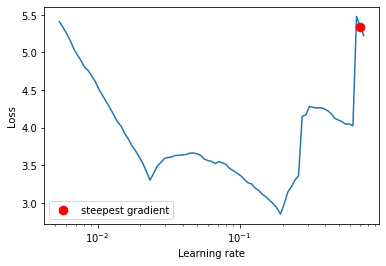

In [260]:
# First find an optimal learning rate.
lr_finder = pyLRFinder(model_qTable_To_NN.get(), optimizer_qTable_To_NN, loss_fn_qTable_To_N)
lr_finder.range_test(trainloader, end_lr=1, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [261]:
# Update optimizer with optimized learning rate.
optimizer_qTable_To_NN = torch.optim.Adam(
            model_qTable_To_NN.get().parameters(), lr=1e-2
        )

In [262]:
# Training loop for the neural net to train on QTable results
loss_batches = []
for epoch in range(1000):

    running_loss = 0.0
    loss_epoch = 0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer_qTable_To_NN.zero_grad()

        # forward + backward + optimize
        outputs = model_qTable_To_NN.get()(inputs.to(dtype=torch.float))
        loss = loss_fn_qTable_To_N(outputs, labels.to(dtype=torch.float)).to(dtype=torch.float)
        loss.backward()
        optimizer_qTable_To_NN.step()

        # Add loss to epoch
        loss_batches.append(loss.item())

    print("epoch: " + str(epoch) + ", Average Loss: " + str(mean(loss_batches)))

print('Finished Training')

epoch: 0, Average Loss: 3.3229644861486225
epoch: 1, Average Loss: 3.2146947930256524
epoch: 2, Average Loss: 3.1342582768864102
epoch: 3, Average Loss: 3.059819869697094
epoch: 4, Average Loss: 2.995350756910112
epoch: 5, Average Loss: 2.9418576569468886
epoch: 6, Average Loss: 2.8986046616993253
epoch: 7, Average Loss: 2.8585080015990467
epoch: 8, Average Loss: 2.820014989302482
epoch: 9, Average Loss: 2.786922181977166
epoch: 10, Average Loss: 2.7542529226553563
epoch: 11, Average Loss: 2.7235268870437586
epoch: 12, Average Loss: 2.6951711361224833
epoch: 13, Average Loss: 2.6691665256780293
epoch: 14, Average Loss: 2.644492325738624
epoch: 15, Average Loss: 2.621753618328108
epoch: 16, Average Loss: 2.599595016124202
epoch: 17, Average Loss: 2.5785281698644895
epoch: 18, Average Loss: 2.559082630956382
epoch: 19, Average Loss: 2.53998595211241
epoch: 20, Average Loss: 2.522299238298305
epoch: 21, Average Loss: 2.5053979913995725
epoch: 22, Average Loss: 2.4887227702543933
epoch: 23

Text(0, 0.5, 'Mean Loss training')

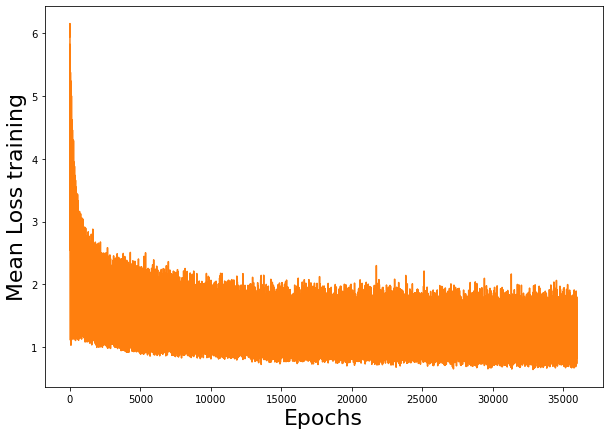

In [263]:
plt.figure(figsize=(10, 7))
plt.plot([])
plt.plot(loss_batches)
plt.xlabel("Epochs", fontsize=22)
plt.ylabel("Mean Loss training", fontsize=22)

In [264]:
# Calculate the validation loss
# Training loop for the neural net to train on QTable results
loss_batches = []

running_loss = 0.0
loss_validation = 0
for i, data in enumerate(validationloader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    # zero the parameter gradients
    with torch.no_grad():
      outputs = model_qTable_To_NN.get()(inputs.to(dtype=torch.float))
      loss = loss_fn_qTable_To_N(outputs, labels.to(dtype=torch.float)).to(dtype=torch.float)
     
      # Add loss to epoch
      loss_batches.append(loss.item())

print('Finished Training')

Finished Training


Text(0, 0.5, 'Mean Loss validation')

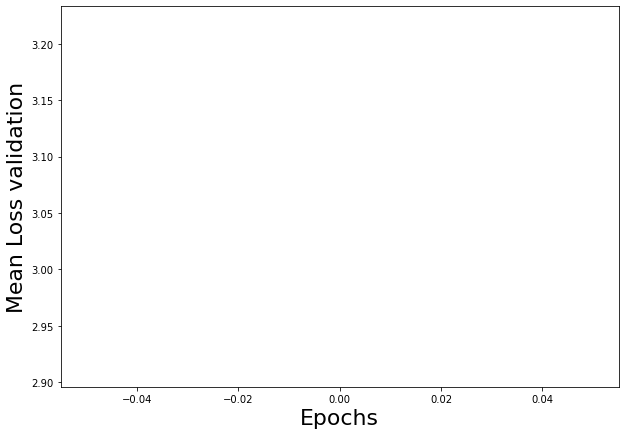

In [265]:
plt.figure(figsize=(10, 7))
plt.plot([])
plt.plot(loss_batches)
plt.xlabel("Epochs", fontsize=22)
plt.ylabel("Mean Loss validation", fontsize=22)

In [266]:
# Simulate a game, where the neural net from QTable plays against random opponent.
games = [playMaker.simulateGame(p1Model=model_qTable_To_NN) for _ in range(1000)]
playMaker.gameStats(games)

Results for player 1:
Wins: 916 (91.6%)
Loss: 32 (3.2%)
Draw: 52 (5.2%)


In [267]:
# Simulate a game, where the neural net from QTable plays against random opponent.
games = [playMaker.simulateGame(p2Model=model_qTable_To_NN) for _ in range(1000)]
playMaker.gameStats(games)

Results for player 1:
Wins: 192 (19.2%)
Loss: 601 (60.1%)
Draw: 207 (20.7%)


In [268]:
game = Game()
game.board = [[0, 2, 2], [2, 1, 1], [1, 2, 1]]
state = game.convertBoardToState()
qTableModel(state)

[4.68559,
 -4.68559,
 -3.439,
 -6.12579511,
 -4.68559,
 -6.12579511,
 -4.0951,
 -2.71,
 -1.9]

In [269]:
model_qTable_To_NN(state)

array([ 7.5869946, -4.343346 , -3.5927768, -4.8211255, -3.6099029,
       -3.828336 , -3.1062315, -3.698046 , -3.3323152], dtype=float32)

In [270]:
train_data_input[0]

array([0., 2., 2., 2., 1., 1., 0., 0., 1.], dtype=float32)

In [271]:
train_data_target[0]

array([ 0. ,  0. , -3.4, -1.9, -1. , -2.7, -1.5, -1. , -1. ],
      dtype=float32)

In [272]:
len(train_data_input)

4590